In [1]:
import sys
import os

new_path = "../xray-segment/"
sys.path.append(new_path)
os.chdir(new_path)

In [2]:
import numpy as np
import gradio as gr
import cv2 
from matplotlib import pyplot as plt

from models.HybridGNet2IGSC import Hybrid 
from utils.utils import scipy_to_torch_sparse, genMatrixesLungsHeart
import scipy.sparse as sp
import torch
import pandas as pd
from zipfile import ZipFile

/Users/hasanfarooq/python/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hybrid = None

def getDenseMask(landmarks, h, w):
    
    RL = landmarks[0:44]
    LL = landmarks[44:94]
    H = landmarks[94:]
    
    img = np.zeros([h, w], dtype = 'uint8')
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')
    H = H.reshape(-1, 1, 2).astype('int')

    img = cv2.drawContours(img, [RL], -1, 1, -1)
    img = cv2.drawContours(img, [LL], -1, 1, -1)
    img = cv2.drawContours(img, [H], -1, 2, -1)
    
    return img

def getMasks(landmarks, h, w):
    
    RL = landmarks[0:44]
    LL = landmarks[44:94]
    H = landmarks[94:]
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')
    H = H.reshape(-1, 1, 2).astype('int')
    
    RL_mask = np.zeros([h, w], dtype = 'uint8')
    LL_mask = np.zeros([h, w], dtype = 'uint8')
    H_mask = np.zeros([h, w], dtype = 'uint8')
    
    RL_mask = cv2.drawContours(RL_mask, [RL], -1, 255, -1)
    LL_mask = cv2.drawContours(LL_mask, [LL], -1, 255, -1)
    H_mask = cv2.drawContours(H_mask, [H], -1, 255, -1)

    return RL_mask, LL_mask, H_mask

def drawOnTop(img, landmarks, original_shape):
    h, w = original_shape
    output = getDenseMask(landmarks, h, w)
    
    image = np.zeros([h, w, 3])
    image[:,:,0] = img + 0.3 * (output == 1).astype('float') - 0.1 * (output == 2).astype('float')
    image[:,:,1] = img + 0.3 * (output == 2).astype('float') - 0.1 * (output == 1).astype('float') 
    image[:,:,2] = img - 0.1 * (output == 1).astype('float') - 0.2 * (output == 2).astype('float') 

    image = np.clip(image, 0, 1)
    
    RL, LL, H = landmarks[0:44], landmarks[44:94], landmarks[94:]
    
    # Draw the landmarks as dots
    
    for l in RL:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 0, 1), -1)
    for l in LL:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 0, 1), -1)
    for l in H:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 1, 0), -1)
    
    return image
    

def loadModel(device):    
    A, AD, D, U = genMatrixesLungsHeart()
    N1 = A.shape[0]
    N2 = AD.shape[0]

    A = sp.csc_matrix(A).tocoo()
    AD = sp.csc_matrix(AD).tocoo()
    D = sp.csc_matrix(D).tocoo()
    U = sp.csc_matrix(U).tocoo()

    D_ = [D.copy()]
    U_ = [U.copy()]

    config = {}

    config['n_nodes'] = [N1, N1, N1, N2, N2, N2]
    A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]
    
    A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

    config['latents'] = 64
    config['inputsize'] = 1024

    f = 32
    config['filters'] = [2, f, f, f, f//2, f//2, f//2]
    config['skip_features'] = f

    hybrid = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
    hybrid.load_state_dict(torch.load("weights/weights.pt", map_location=torch.device(device)))
    hybrid.eval()
    
    return hybrid


def pad_to_square(img):
    h, w = img.shape[:2]
    
    if h > w:
        padw = (h - w) 
        auxw = padw % 2
        img = np.pad(img, ((0, 0), (padw//2, padw//2 + auxw)), 'constant')
        
        padh = 0
        auxh = 0
        
    else:
        padh = (w - h) 
        auxh = padh % 2
        img = np.pad(img, ((padh//2, padh//2 + auxh), (0, 0)), 'constant')

        padw = 0
        auxw = 0
        
    return img, (padh, padw, auxh, auxw)
    

def preprocess(input_img):
    img, padding = pad_to_square(input_img)
    
    h, w = img.shape[:2]
    if h != 1024 or w != 1024:
        img = cv2.resize(img, (1024, 1024), interpolation = cv2.INTER_CUBIC)
        
    return img, (h, w, padding)


def removePreprocess(output, info):
    h, w, padding = info
    
    if h != 1024 or w != 1024:
        output = output * h
    else:
        output = output * 1024
    
    padh, padw, auxh, auxw = padding
    
    output[:, 0] = output[:, 0] - padw//2
    output[:, 1] = output[:, 1] - padh//2
    
    return output   


def zip_files(files):
    with ZipFile("complete_results.zip", "w") as zipObj:
        for idx, file in enumerate(files):
            zipObj.write(file, arcname=file.split("/")[-1])
    return "complete_results.zip"



In [4]:
def segment_image(input_img):
    global hybrid, device
    
    if hybrid is None:
        hybrid = loadModel(device)
    
    input_img = cv2.imread(input_img, 0) / 255.0
    original_shape = input_img.shape[:2]
    
    img, (h, w, padding) = preprocess(input_img)
        
    data = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device).float()
    
    with torch.no_grad():
        output = hybrid(data)[0].cpu().numpy().reshape(-1, 2)
        
    output = removePreprocess(output, (h, w, padding))
    
    output = output.astype('int')
    
    outseg = drawOnTop(input_img, output, original_shape) 
    
    seg_to_save = (outseg.copy() * 255).astype('uint8')
    cv2.imwrite("tmp/overlap_segmentation.png" , cv2.cvtColor(seg_to_save, cv2.COLOR_RGB2BGR))
    
    RL = output[0:44]
    LL = output[44:94]
    H = output[94:]
            
    np.savetxt("tmp/RL_landmarks.txt", RL, delimiter=" ", fmt="%d")
    np.savetxt("tmp/LL_landmarks.txt", LL, delimiter=" ", fmt="%d")
    np.savetxt("tmp/H_landmarks.txt", H, delimiter=" ", fmt="%d")
    
    RL_mask, LL_mask, H_mask = getMasks(output, original_shape[0], original_shape[1])
    
    cv2.imwrite("tmp/RL_mask.png", RL_mask)
    cv2.imwrite("tmp/LL_mask.png", LL_mask)
    cv2.imwrite("tmp/H_mask.png", H_mask)
    
    zip = zip_files(["tmp/RL_landmarks.txt", "tmp/LL_landmarks.txt", "tmp/H_landmarks.txt", "tmp/RL_mask.png", "tmp/LL_mask.png", "tmp/H_mask.png", "tmp/overlap_segmentation.png"])    
    
    return outseg, ["tmp/RL_landmarks.txt", "tmp/LL_landmarks.txt", "tmp/H_landmarks.txt", "tmp/RL_mask.png", "tmp/LL_mask.png", "tmp/H_mask.png", "tmp/overlap_segmentation.png", zip]


In [5]:
image_path = "/Users/hasanfarooq/Desktop/others/sample.png"

In [6]:
results = segment_image(image_path)

/Users/hasanfarooq/python/xray-segment/utils/utils.py:12: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:643.)
  sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))
/var/folders/5s/qdqvlk9n7pd4k89bspzznr6c0000gp/T/ipykernel_31307/3243665792.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects 

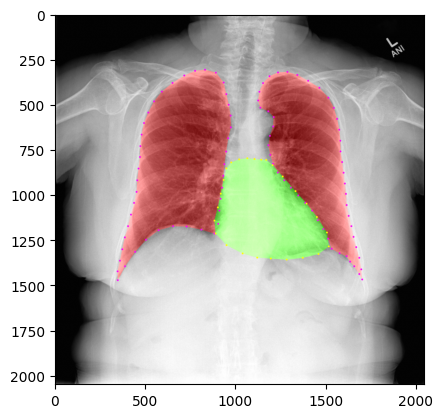

In [7]:
plt.imshow(results[0])